In [256]:
import pyro
import torch
from pyro.infer.autoguide import AutoNormal, AutoMultivariateNormal
import pyro.distributions as dist
import matplotlib.pyplot as plt
import seaborn as sns
from contextlib import ExitStack
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.infer import Predictive

from causal_pyro.dynamical.handlers import (
    PointObservation,
    SimulatorEventLoop,
    simulate,
    ODEDynamics
)
from causal_pyro.dynamical.ops import State, Trajectory

sns.set_style("white")

In [170]:
class SimpleSIRDynamics(ODEDynamics):
    def __init__(self, beta, gamma):
        super().__init__()
        self.beta = beta
        self.gamma = gamma

    def diff(self, dX: State[torch.Tensor], X: State[torch.Tensor]):
        dX.S = -self.beta * X.S * X.I
        dX.I = self.beta * X.S * X.I - self.gamma * X.I  # noqa
        dX.R = self.gamma * X.I

    def observation(self, X: State[torch.Tensor]):
        test_kit_sales = torch.relu(pyro.sample("test_kit_sales", dist.Normal(torch.log(X.S + 1), 1)))
        I_obs = pyro.sample("I_obs", dist.Poisson(X.I)) # noisy number of infected actually observed
        R_obs = pyro.sample("R_obs", dist.Poisson(X.R)) # noisy number of recovered actually observed
        return {"test_kit_sales": test_kit_sales, "I_obs": I_obs, "R_obs": R_obs}

# Generate synthetic data from an SIR model

In [171]:
# Assume there is initially a population of 99 million people that are susceptible, 1 million infected, and 0 recovered
init_state = State(S=torch.tensor(99.), I=torch.tensor(1.), R=torch.tensor(0.))
time_period = torch.linspace(0, 3, steps=21)

# We would like to estimate the beta and gamma parameters defining the SIR model 
def model():
    beta = pyro.sample("beta", dist.Uniform(0, .25))
    gamma = pyro.sample("gamma", dist.Uniform(0, 1))
    sir = SimpleSIRDynamics(beta, gamma)
    return sir

# We now simulate from the SIR model
sir = model()
sir_traj = simulate(sir, init_state, time_period)

### Plot the simulated trajectories from SIR model

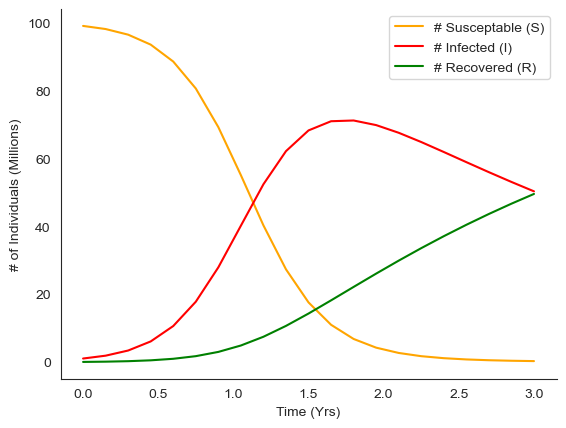

In [172]:
sns.lineplot(x=time_period, y=sir_traj.S, label="# Susceptable (S)", color='orange')
sns.lineplot(x=time_period, y=sir_traj.I, label="# Infected (I)", color='red')
sns.lineplot(x=time_period, y=sir_traj.R, label="# Recovered (R)", color='green')
sns.despine()
plt.xlabel("Time (Yrs)")
plt.ylabel("# of Individuals (Millions)")
plt.legend()

### Sample observed data from the model
 

In [182]:
obs_time_period = torch.arange(0, 2.01, 1/52) # collect data every week for past 2yrs
N_obs = obs_time_period.shape[0]
sir_obs_traj = simulate(sir, init_state, obs_time_period)
data = dict()
for time_ix in range(N_obs):
    data[time_ix] = [obs_time_period[time_ix], sir.observation(sir_obs_traj[time_ix])]

In [207]:
test_kit_sales = torch.stack([data[time_ix][1]["test_kit_sales"] for time_ix in range(N_obs)])
I_obs = torch.stack([data[time_ix][1]["I_obs"] for time_ix in range(N_obs)])
R_obs = torch.stack([data[time_ix][1]["R_obs"] for time_ix in range(N_obs)])

Text(0, 0.5, 'Observed # Recovered (Millions)')

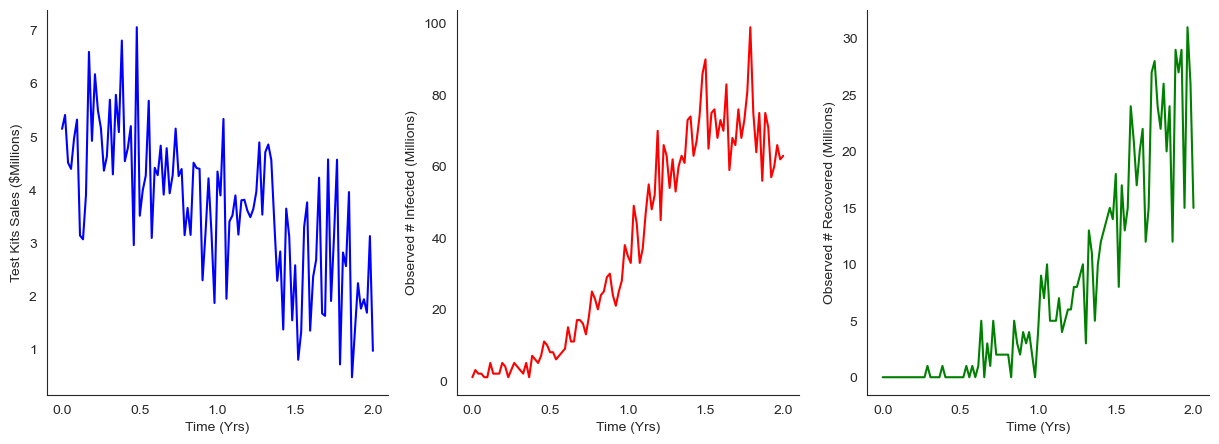

In [208]:
# Plot observed data
fix, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plot test kit sales
sns.lineplot(x=obs_time_period, y=test_kit_sales, color='blue', ax=ax[0])
sns.despine()
ax[0].set_xlabel("Time (Yrs)")
ax[0].set_ylabel("Test Kits Sales ($Millions)")

# Plot observed infected
sns.lineplot(x=obs_time_period, y=I_obs, color='red', ax=ax[1])
sns.despine()
ax[1].set_xlabel("Time (Yrs)")
ax[1].set_ylabel("Observed # Infected (Millions)")

# Plot observed recovered
sns.lineplot(x=obs_time_period, y=R_obs, color='green', ax=ax[2])
sns.despine()
ax[2].set_xlabel("Time (Yrs)")
ax[2].set_ylabel("Observed # Recovered (Millions)")

# Perform Inference!

In [234]:
def conditioned_sir(data, init_state, tspan):
    sir = model()
    observation_managers = []
    for obs in data.values():
        obs_time = obs[0].item()
        obs_data = obs[1]
        observation_managers.append(PointObservation(obs_time, obs_data))
    with SimulatorEventLoop():
        with ExitStack() as stack:
            for manager in observation_managers:
                stack.enter_context(manager)
            traj = simulate(sir, init_state, tspan)
    return traj

In [235]:
# with pyro.poutine.trace() as tr:
#     traj = conditioned_sir(data, init_state, time_period)

# tr.trace.log_prob_sum()

In [251]:
guide = AutoMultivariateNormal(conditioned_sir)
# set up the optimizer
adam = pyro.optim.Adam({"lr": 0.03})

# setup the inference algorithm
svi = SVI(conditioned_sir, guide, adam, loss=Trace_ELBO())

n_steps = 100
# do gradient steps
pyro.clear_param_store()
for step in range(n_steps):
    loss = svi.step(data, init_state, torch.tensor([0., 3.]))
    print("[iteration %04d] loss: %.4f" % (step + 1, loss / N_obs))
    guide_median = guide.median()
    print("beta Est: %.4f, gamma est: %.4f" % (guide_median['beta'].item(), guide_median['gamma'].item()))
        

[iteration 0001] loss: 13.8005
beta Est: 0.0680, gamma est: 0.5161
[iteration 0002] loss: 12.7279
beta Est: 0.0665, gamma est: 0.5086
[iteration 0003] loss: 15.9454
beta Est: 0.0651, gamma est: 0.5011
[iteration 0004] loss: 12.3092
beta Est: 0.0636, gamma est: 0.4937
[iteration 0005] loss: 12.2595
beta Est: 0.0622, gamma est: 0.4864
[iteration 0006] loss: 11.4507
beta Est: 0.0608, gamma est: 0.4792
[iteration 0007] loss: 10.2271
beta Est: 0.0595, gamma est: 0.4720
[iteration 0008] loss: 8.5259
beta Est: 0.0582, gamma est: 0.4650
[iteration 0009] loss: 10.2214
beta Est: 0.0569, gamma est: 0.4582
[iteration 0010] loss: 7.9969
beta Est: 0.0557, gamma est: 0.4515
[iteration 0011] loss: 10.7833
beta Est: 0.0544, gamma est: 0.4451
[iteration 0012] loss: 7.2902
beta Est: 0.0533, gamma est: 0.4388
[iteration 0013] loss: 8.1334
beta Est: 0.0521, gamma est: 0.4326
[iteration 0014] loss: 6.4568
beta Est: 0.0511, gamma est: 0.4267
[iteration 0015] loss: 6.6285
beta Est: 0.0501, gamma est: 0.4211
[

In [253]:
guide.quantiles([0.25, 0.5, 0.75])

{'beta': tensor([0.0448, 0.0460, 0.0473]),
 'gamma': tensor([0.3496, 0.3616, 0.3738])}

In [254]:
sir.beta

tensor(0.0450)

In [255]:
sir.gamma

tensor(0.3708)

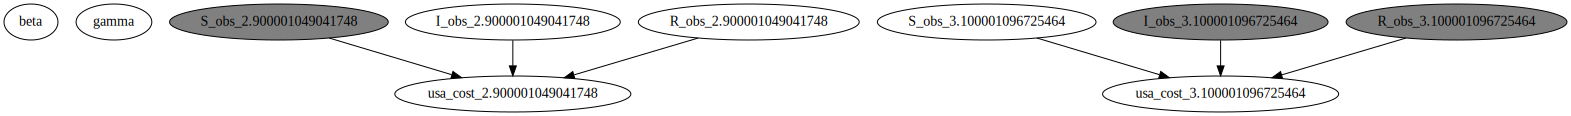

In [67]:
pyro.render_model(model)

In [38]:
# Generate different states for a number of different countries
# Each country conditional on covariates, has same dynamics

# Some countries enact different policies at different times
# pool all information together to estimate dynamics

# References
1. https://www.generable.com/post/fitting-a-basic-sir-model-in-stan